In [3]:
%matplotlib notebook
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
from tqdm import tqdm_notebook
import math

from numpy.random import multivariate_normal as draw_mn
from numpy.random import chisquare as draw_cs
from scipy.stats import chi2
from scipy.stats import multivariate_normal
from scipy.special import gamma, gammaln

In [4]:
class multivariate_t_distribution:
    def __init__(self,mu,Sigma,df):
        self.d = len(mu)
        self.df = df
        self.num = gamma((self.d+self.df)/2.)
        self.invSig = np.linalg.inv(Sigma)
        self.fact = gamma(df/2.) * np.power(df*np.pi,self.d/2.) * np.sqrt(np.linalg.det(Sigma))
        
        
        
    def pdf(self, x):
        return self.num/(self.fact*np.power(1. + (1./self.df)*np.dot(np.dot((x - mu), self.invSig), (x - mu)),(self.d+self.df)/2.0))

# Importance Sampling Test
## Parameters

In [147]:
D = 90
mu = 0.2
mu_vec = np.full((D), mu)
samples = 10000
nu = 3 # Degrees of freedom
Sigma = 0.5*np.eye(D); Sigma[0,D-1] = 0.8; Sigma[D-1,0] = 0.8; Sigma[int(D/2),2] = 1.2
Sigma = Sigma*Sigma.T; Sigma = Sigma + D*np.eye(D)
L = np.linalg.cholesky(Sigma)
def f(x):
    return np.mean(x)

## Importance sampling test for $\mathcal{N}(\mu, \Sigma)$ from $\mathcal{N}(0, 1)$

In [48]:
mvn0 =  multivariate_normal(mean=np.full((D), mu+0.1), cov=1.2*Sigma, allow_singular=False)
mvn =  multivariate_normal(mean=mu_vec, cov=Sigma, allow_singular=False)
Z0 = mvn0.rvs(samples)#draw_mn(np.full((D), 0.), np.eye(D), samples)

X = mvn0.rvs(samples)#mu_vec + np.array([L.dot(Z0i) for Z0i in Z0])
#Linv = np.linalg.inv(L)
prob_factor = 1.#np.log(np.linalg.det(L))
q = np.array([ mvn0.pdf(Xi) for Xi in X])
p = np.array([ mvn.pdf(Xi) for Xi in X])
weight = prob_factor*p/q#np.exp(log_p+log_prob_factor-log_q)#

## Importance sampling test for $t_{\nu}(\mu, \Sigma)$ from $\mathcal{N}(0, 1)$ and $\chi^2(\nu)$ 
Loop version

In [162]:
mvt = multivariate_t_distribution(mu_vec,Sigma, nu) #
mvn0 =  multivariate_normal(mean=np.full((D), 0.0), cov=np.eye(D), allow_singular=False)
mvn =  multivariate_normal(mean=mu_vec, cov=Sigma, allow_singular=False)
chi2_dist = chi2(nu)

Z0 = mvn0.rvs(samples)                            # draw N(0,1) samples
c = chi2_dist.rvs(samples)                        # draw chi2 samples
weight = np.zeros(samples, dtype=np.longdouble)
X = np.zeros((samples, D), dtype=np.longdouble)

for i in range(samples):
    Lchi = np.sqrt(float(nu)/c[i])*L
    #Sigmap = Lchi.dot(Lchi.conj().T)
    #Lchi_inv = np.linalg.inv(Lchi)
    #prob_factor = 1.#np.log(np.linalg.det(Lchi))#np.log(np.abs(np.linalg.det(np.linalg.inv(Lchi))))
    #mvn2 =  multivariate_normal(mean=mu_vec, cov=Sigmap, allow_singular=False)
    
    X[i] = mu_vec + Lchi.dot(Z0[i]) 
    log_q = np.log(mvt.pdf(X[i]))
    log_p =  mvn.logpdf(X[i]) #- chi2_dist.logpdf(c[i])#mvn2.logpdf(X[i]) + chi2_dist.logpdf(c[i])#
    weight[i] = np.exp(log_p-log_q, dtype=np.longdouble)#prob_factor*p/q#

Vectorized version

In [163]:
print( np.mean(weight) )
print( np.mean( np.apply_along_axis(f, 1, Z0) ) )
print( np.mean( np.apply_along_axis(f, 1, Z0)*weight))
print( np.mean( np.apply_along_axis(f, 1, X) ))
print( np.mean( np.apply_along_axis(f, 1, X)*weight))

0.95812947997090349946
0.0008160398534963559
-0.00049541224358130782904
0.21037537022677909623
0.1861397335695495317


# Plots

<IPython.core.display.Javascript object>


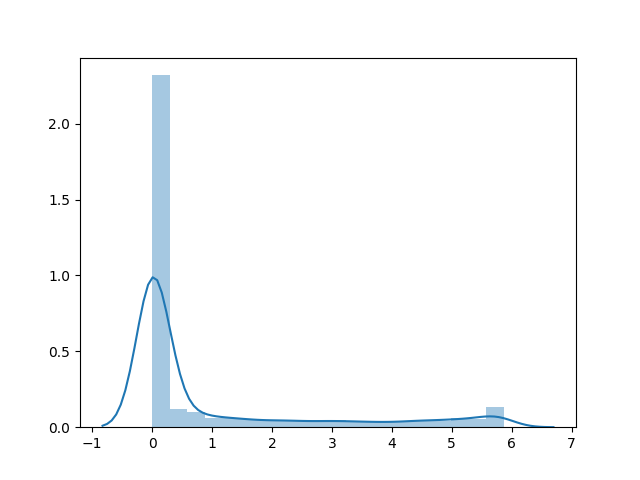

0.95812947997090349946


In [164]:
r = sns.distplot(weight, bins=20, hist=True)
print(np.mean(weight))

# 2D stuff

In [ ]:
df_Z = pd.DataFrame(Z, columns=["x", "y"])
df_X = pd.DataFrame(X, columns=["x", "y"])

<IPython.core.display.Javascript object>


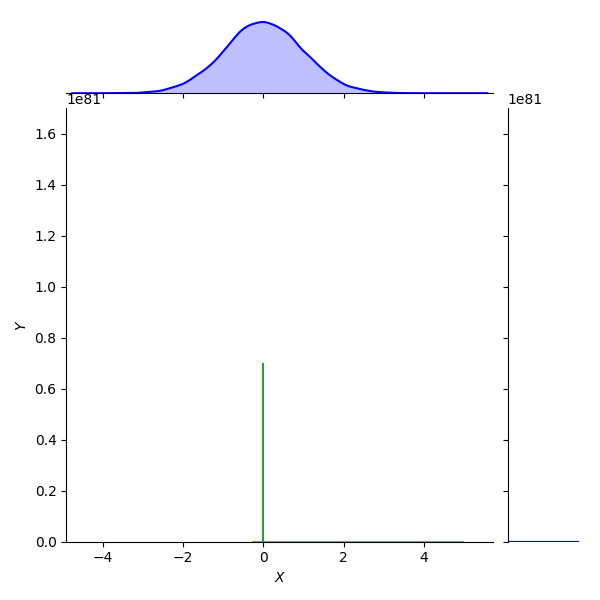

In [15]:
g = sns.jointplot(x="x", y="y", data=df_Z, kind="kde", color="b")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

<IPython.core.display.Javascript object>


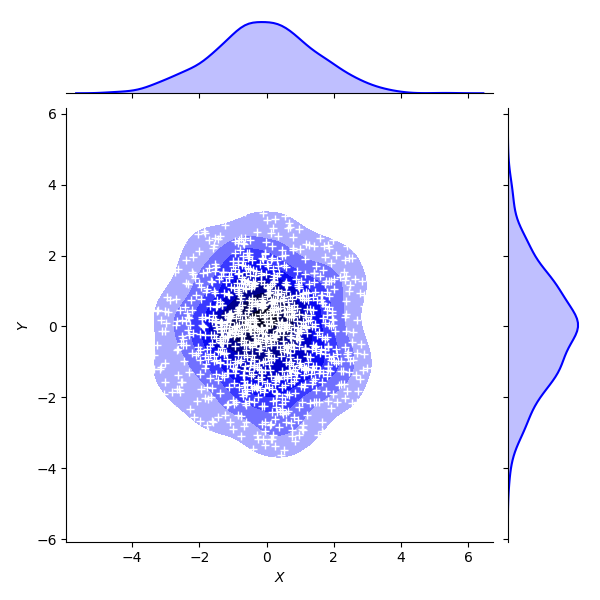

In [42]:
g = sns.jointplot(x="x", y="y", data=df_X, kind="kde", color="b")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");